In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs (1=INFO, 2=WARNING, 3=ERROR)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disables GPU and forces TensorFlow to use CPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'  # Prevent any GPU initialization

import tensorflow as tf


E0000 00:00:1732546097.884448   12213 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732546097.889326   12213 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [18]:
# set parameter
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [6]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

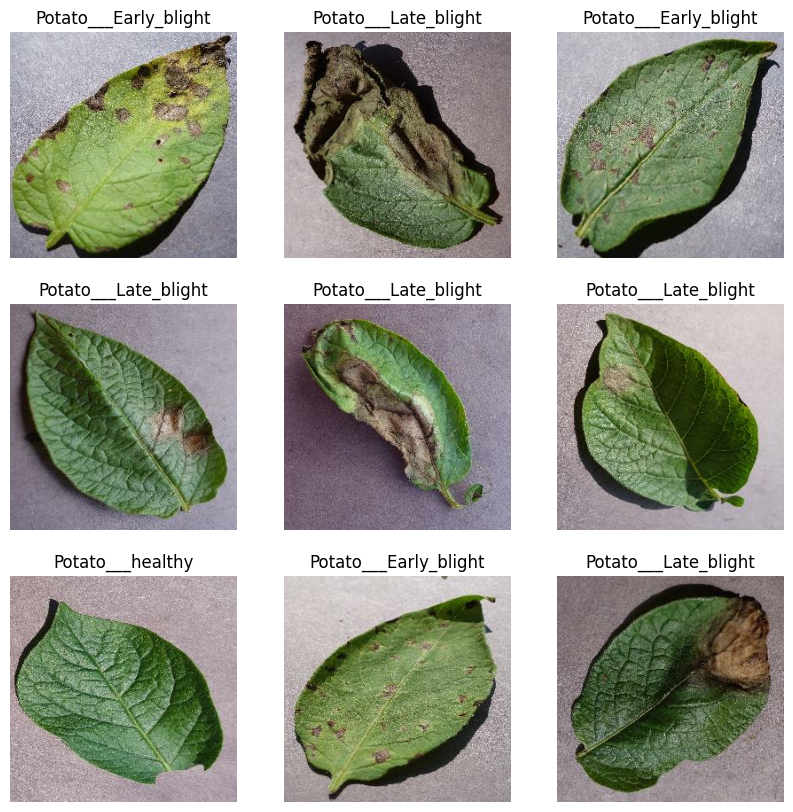

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")
plt.show()

In [9]:
train_ds = dataset.take(54)
test_ds = dataset.skip(54)
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)

In [10]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [11]:
def get_dataset_partition_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_buffer_size=10000):
    """
    Splits a TensorFlow dataset into training, validation, and test sets.

    Parameters:
    - dataset (tf.data.Dataset): The input TensorFlow dataset to be split.
    - train_split (float, optional): Proportion of the dataset to be used for training (default is 0.8).
    - val_split (float, optional): Proportion of the dataset to be used for validation (default is 0.1).
    - test_split (float, optional): Proportion of the dataset to be used for testing (default is 0.1).
    - shuffle (bool, optional): Whether to shuffle the dataset before splitting (default is True).
    - shuffle_buffer_size (int, optional): Size of the buffer to use for shuffling (default is 10000).

    Returns:
    - train_dataset (tf.data.Dataset): The training dataset.
    - val_dataset (tf.data.Dataset): The validation dataset.
    - test_dataset (tf.data.Dataset): The test dataset.
    """
    
    # Get the total size of the dataset
    total_size = len(dataset)

    # Shuffle the dataset if requested
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer_size, seed=12)

    # Calculate the sizes for each split
    train_size = int(train_split * total_size)
    val_size = int(val_split * total_size)

    # Partition the dataset into train, validation, and test sets
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset


In [12]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [15]:
# AUTOTUNE for better performance
AUTOTUNE = tf.data.AUTOTUNE

# Ensure train_ds, val_ds, and test_ds are TensorFlow datasets, not functions
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize to the target size
    layers.Rescaling(1./255)                 # Rescale pixel values to [0, 1]
])


In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),  # Randomly flip images
    layers.RandomRotation(0.2),                   # Randomly rotate images
])


# Why Use CNNs for Image Data?

Given that my task involves **image data** (detecting blight in potato plants), using a **Convolutional Neural Network (CNN)** is the most appropriate choice. Here's why:

## **1. Spatial Hierarchies**

- CNNs are specifically designed to recognize patterns in images by preserving **spatial relationships** (e.g., edges, shapes).
- Convolutional layers focus on **local features** (e.g., small textures or shapes) and build up to more complex features.

## **2. Efficiency**

- CNNs use **shared weights (kernels)**, reducing the number of parameters compared to fully connected layers.
- This makes them **computationally efficient** for image data, even for large datasets.

## **3. Robustness to Variations**

- CNNs can handle variations in **scale, rotation, and lighting**, especially when combined with **data augmentation**.
- This robustness is critical for tasks like **plant blight detection** where conditions vary.

## **4. Proven Success**

- CNNs are the **gold standard** for image classification, segmentation, and object detection tasks.
- They’ve been used successfully in many **agricultural applications**, including **disease detection in plants**.


In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Block 3
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 4
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

      # Convolutional Block 5
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

      # Convolutional Block 6
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),

    # Output Layer
    layers.Dense(3, activation='softmax')  # Match the number of classes
])

# Build the model explicitly
model.build(input_shape=input_shape)  


/home/martins/Work/Data Science/potatoes_disease_project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,  # Allow 5 epochs with no improvement
#     restore_best_weights=True,
#     min_delta=0.01  # Set a small minimum change to consider as improvement
# )


history = model.fit(
    train_ds,
    epochs=10,  
    batch_size=BATCH_SIZE,  # Corrected the missing comma
    verbose=1,
    validation_data=val_ds,
    # callbacks=[early_stopping]
)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - accuracy: 0.9506 - loss: 0.1355 - val_accuracy: 0.8854 - val_loss: 0.2721
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 511ms/step - accuracy: 0.9486 - loss: 0.1395 - val_accuracy: 0.8021 - val_loss: 0.5995
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 573ms/step - accuracy: 0.9340 - loss: 0.1754 - val_accuracy: 0.9323 - val_loss: 0.1443
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.9708 - loss: 0.0898 - val_accuracy: 0.9896 - val_loss: 0.0525
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 978ms/step - accuracy: 0.9657 - loss: 0.0933 - val_accuracy: 0.9219 - val_loss: 0.2029
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step - accuracy: 0.9610 - loss: 0.1337 - val_accuracy: 0.9531 - val_loss: 0.1262
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 576ms/step - accuracy: 0.9520 - loss: 0.1348 - val_accuracy: 0.9792 - val_loss: 0.0587
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - accuracy: 0.9728 - loss: 0.0794 - val_accuracy

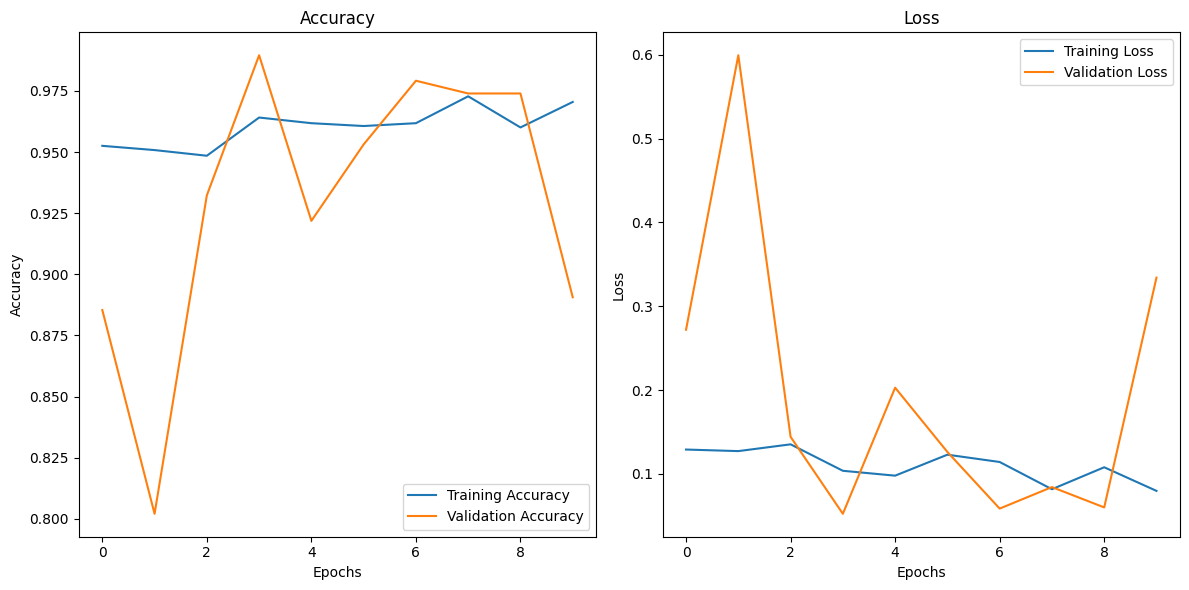

In [28]:
# Plot accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.9138 - loss: 0.2339


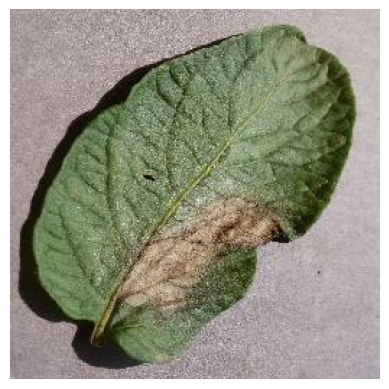

First image actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
predicted label Potato___Early_blight


In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_ds is your test dataset and class_names is defined
for images, labels in test_ds.take(1):  # Take the first batch
    first_image = images[0].numpy().astype('uint8')  # Convert the image to a numpy array with uint8 type for displaying
    first_label = labels[0].numpy()  # The actual label of the image
    
    # Plot the first image
    plt.imshow(first_image)
    plt.axis('off')  # Hide axes for better display
    plt.show()

    # Print the actual label
    print('First image actual label:', classes[first_label])

    batch_prediction = model.predict(images)
    print('predicted label', classes[np.argmax(batch_prediction[0])])


In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())  # Ensure you pass the right image
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)  # Round to 2 decimal places

    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


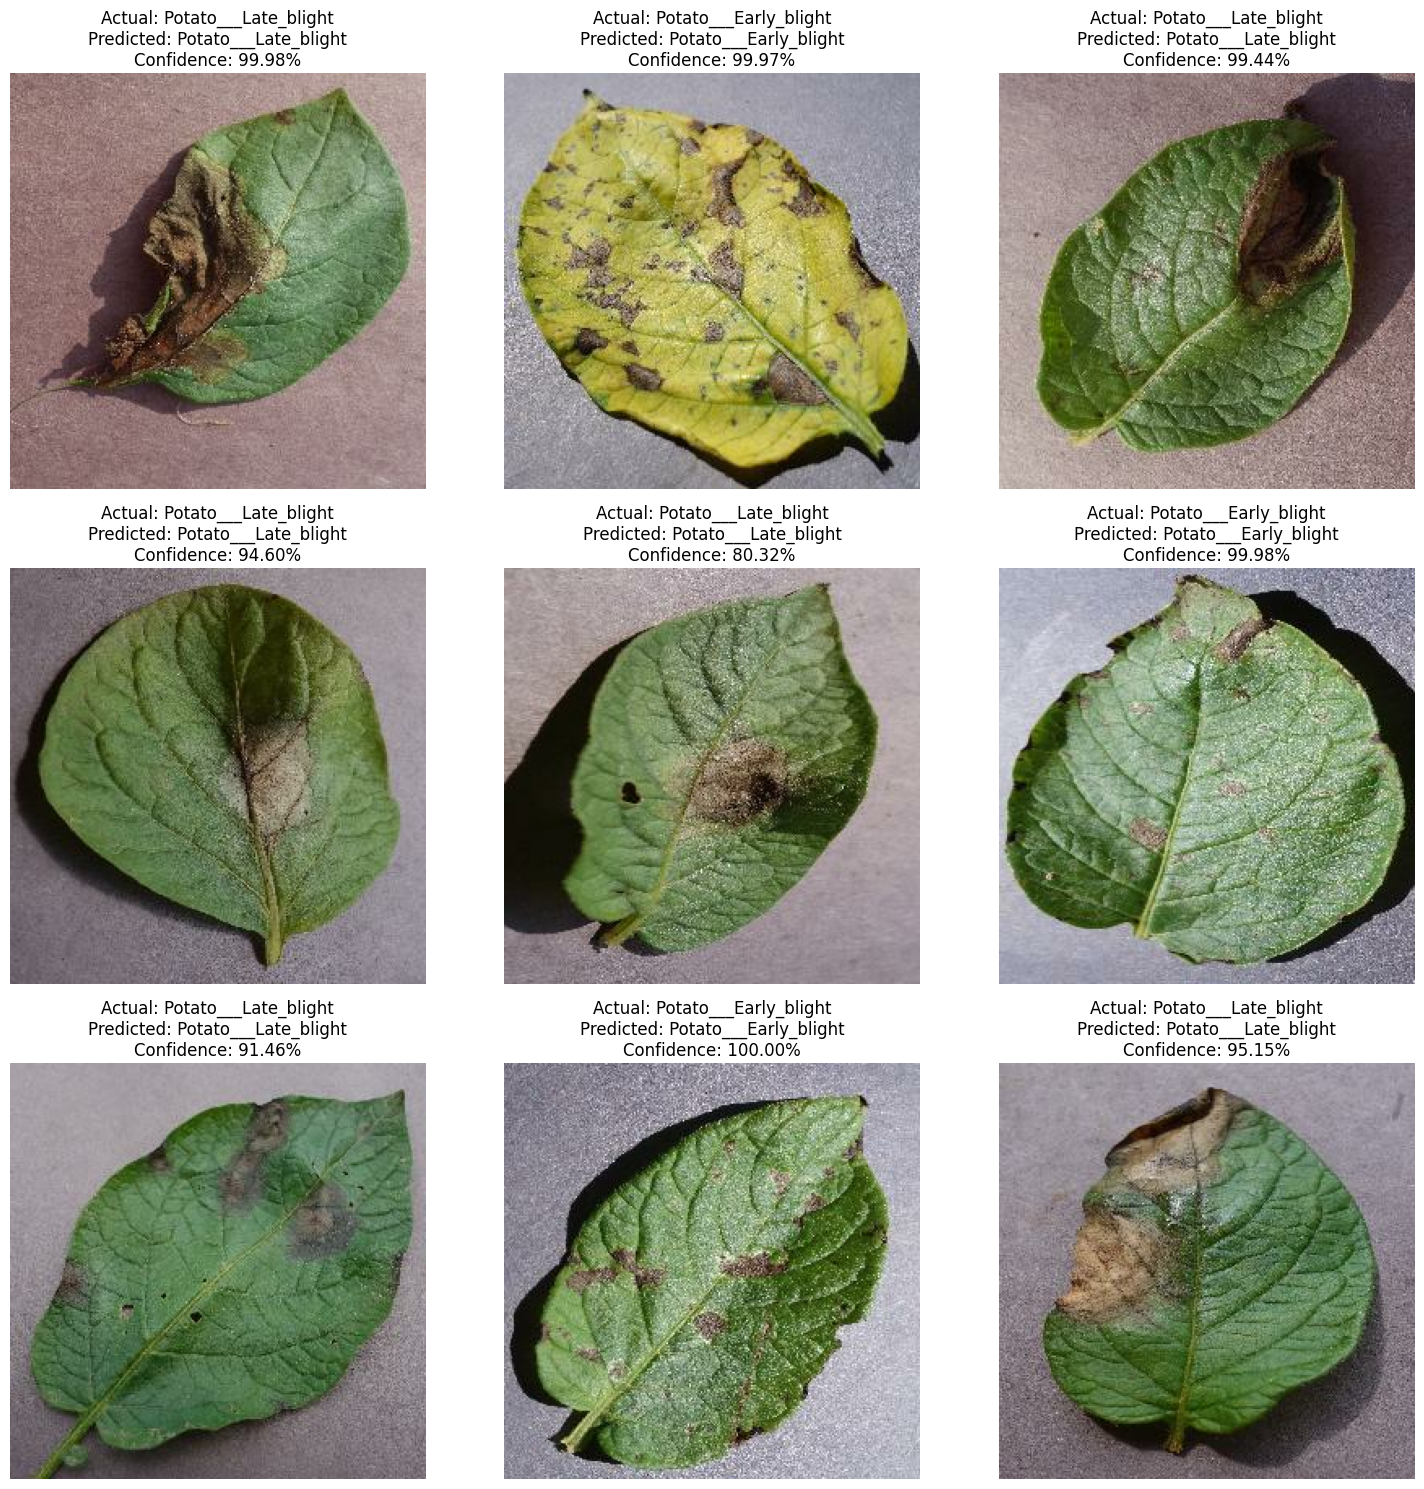

In [72]:
# Prepare the plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid for 9 images
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Initialize counter for images
image_count = 0

# Iterate through the dataset and grab images until we have 9
for images, labels in test_ds:  # No need for enumerate here
    if image_count >= 9:  # Stop after 9 images
        break

    for idx in range(len(images)):
        if image_count >= 9:  # Stop if we've reached 9 images
            break

        # Get the current image
        image = images[idx].numpy().astype('uint8')  # Convert to numpy array for display
        actual_label = labels[idx].numpy()  # Actual label of the image

        # Make a prediction using the 'predict' function
        predicted_class, confidence = predict(model, images[idx])

        # Plot the image and display the actual and predicted labels
        ax = axes[image_count]
        ax.imshow(image)
        ax.axis('off')  # Turn off the axis for cleaner display

        # Set the title with actual label and predicted class with confidence
        ax.set_title(f'Actual: {classes[actual_label]}\n'
             f'Predicted: {predicted_class}\n'
             f'Confidence: {confidence:.2f}%')


        # Increment the image counter
        image_count += 1

# Display the plot
plt.tight_layout()
plt.show()


In [73]:
model_version = 1
model.save(f'../models/model_{model_version}')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=../models/model_1.